### Physics-informed Operator Learning in TorchPhysics

We keep the integral operator given by the ODE
\begin{align*}
    \partial_t u(t) &= 5.0f(t) \quad \text{ in } (0, 1), \\
    u(0) &= 0.
\end{align*}
from the previous example. Still, our goal is to train one network that outpus $u$ for a given $f$. However, we now dont have data set consisting of pairs $(u, f)$. Instead we use the PINN-idea from the first examples to train our network.

In [18]:
# This block is for GPU selection. Please execute.
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from data_gen_deeponet import integrator

We load the data as before. The data for $f$ will be used in the training, the data for $u$ only later for validation!

Time discretization: 100
Available data points: 20500
Shape of data: torch.Size([20500, 100, 1])


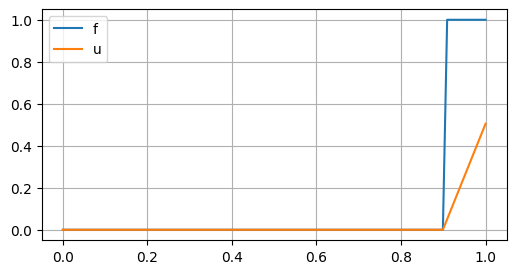

In [19]:
save_path = "/localdata/tomfre/DeepONet_data_integrator"
input_t = torch.load(f"{save_path}/input_t.pt")
input_f = torch.load(f"{save_path}/input_f.pt")
output_u = torch.load(f"{save_path}/output_u.pt")

step_f = torch.zeros((500, len(input_t), 1))
t_0_random = torch.rand((500, 1, 1))
step_f[:] = (t_0_random[:] <= input_t)
step_u = integrator(input_t, step_f)

input_f = torch.cat((step_f, input_f), dim=0)
output_u = torch.cat((step_u, output_u), dim=0)

print("Time discretization:", len(input_t))
print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

example_idx = 0
plt.figure(0, figsize=(6, 3))
plt.plot(input_t, input_f[example_idx])
plt.plot(input_t, output_u[example_idx])
plt.grid()
leg = plt.legend(["f", "u"])

The spaces are the same as in the previous example.

In [20]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

# TODO: Add the correct function spaces
fn_space_F = tp.spaces.FunctionSpace(T, F) 
fn_space_U = tp.spaces.FunctionSpace(T, U)

Given that we now use physics-informed loss terms, we also need to define our domain as we did in the first two examples.

In [21]:
I_t = tp.domains.Interval(T, 0, 1) # TODO: define the unit interval (0, 1)

We still select 80% from our available functions $f$ for the training process.

In [22]:
# Split data into training and testing:
total_data = len(input_f)

# TODO: select 80% of total_data and set train_f accordingly.
train_N = int(0.8*total_data)

train_f = input_f[:train_N]
# Note: no train_u here, since we assume this data is not available!

test_f = input_f[train_N:]
test_u = output_u[train_N:]

# Define FunctionSet (DataSet)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_F, train_f)

Next up are the samplers. Again we need the sampler to load the sample functions $f$. But now we also need to additional samplers that create points in $(0, 1)$ to evaluate our physics informed loss.

Note: Our functions $f$ are already discrete and fixed on the grid *input_t*, hence for the *ode_sampler* we create a sampler that just returns the given grid.

In [23]:
# TODO: Complete the FunctionSampler, which should return 6000 samples of f when called.
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(6000, data_functionset_input)

ode_sampler = tp.samplers.DataSampler(tp.spaces.Points(input_t, T))
initial_sampler = tp.samplers.RandomUniformSampler(I_t.boundary_left, 1)

The DeepONet is the same as in the previous example. 

In [24]:
### DeepONet
trunk_net = tp.models.FCTrunkNet(T, default_trunk_input=input_t, hidden=(30, 30, 30))
branch_net = tp.models.FCBranchNet(fn_space_F, hidden=(50, 50, 50), grid=input_t)

model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=50) # TODO: Add the first 3 arguments

As for the PINN approach, we now have to create two conditions that implement our problem.
Starting with the ODE $\partial_t u - 5.0 f = 0$.

As for the *PINNCondition*, we have the *PIDeepONetCondition* that handles the implementation internally. We only have to finish the residual function.

In [25]:
# TODO: Finish the residual function
def ode_residual(u, t, f):
    return tp.utils.grad(u, t) - 5.0*f

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             branch_function_sampler=functionsampler_input, 
                                             trunk_points_sampler=ode_sampler, 
                                             residual_fn=ode_residual)

Next is the initial condition $u(0)=0$.

In [26]:
# TODO: Finish the initial residual
def initial_residual(u):
    return u

# TODO: Add the correct arguments to the condition
initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                 branch_function_sampler=functionsampler_input, 
                                                 trunk_points_sampler=initial_sampler, 
                                                 residual_fn=initial_residual)

Next, we start the training:

In [27]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.002,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 2500, "gamma":0.2})
solver = tp.solver.Solver([ode_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=10000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 16.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
16.2 K    Trainable params
0         Non-trainable params
16.2 K    Total params
0.065     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 10000/10000 [03:27<00:00, 48.21it/s, train/loss=1.390]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [03:27<00:00, 48.21it/s, train/loss=1.390]


Let us check the perfomance on the unseen testing data:

In [28]:
model_output = model(branch_inputs=tp.spaces.Points(test_f, F)).as_tensor.detach()
rel_error = torch.max(torch.abs(model_output - test_u)) / torch.max(torch.abs(test_u))
print(f"Relative error on test data: {rel_error*100} %")

Relative error on test data: 4.5205278396606445 %


Example plot:


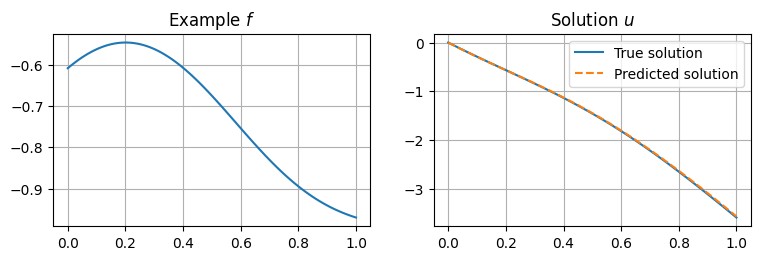

In [29]:
plot_idx = 340

print("Example plot:")
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, test_f[plot_idx])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, test_u[plot_idx])
axarr[1].plot(input_t, model_output[plot_idx], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])

We can now ask ourselfs how well the model performs on data not included in the data set.
The trainings consits of oscillating functions and polynomials. So let us check how well the model performs on step functions. Choose an $t_0 \in (0, 1)$ and define 
\begin{equation}
    f(t)  = \begin{cases}
            1 \quad &\text{if } t \geq t_0, \\
            0 \quad &\text{if } t < t_0.
        \end{cases}
\end{equation}

Test:


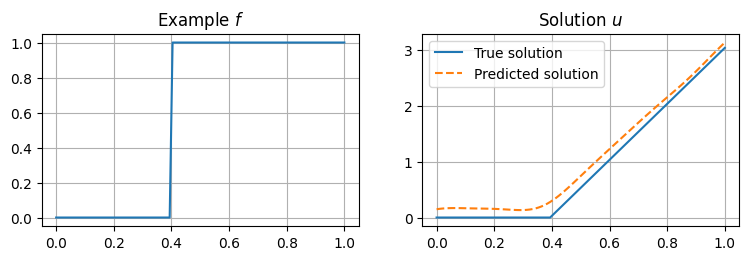

In [30]:
new_f = torch.zeros((1, len(input_t), 1))

#####################################################
# TODO: Here implement your function:
t_0 = 0.4
new_f[0] = (t_0 <= input_t)


#####################################################
expected_u = integrator(input_t, new_f)
model_output = model(branch_inputs=tp.spaces.Points(new_f, F)).as_tensor.detach()
print("Test:")
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, new_f[0])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, expected_u[0])
axarr[1].plot(input_t, model_output[0], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])

The prefomance should be not so good. But we can maybe add some example functions to our train set and hope that this improves the result!
The following code needs to be copied in the second cell, after we load the data, to add some steps functions to our training set. Then run the notebook again and see if this improves the result.

In [31]:
step_f = torch.zeros((500, len(input_t), 1))
t_0_random = torch.rand((500, 1, 1))
step_f[:] = (t_0_random[:] <= input_t)
step_u = integrator(input_t, step_f)

input_f = torch.cat((step_f, input_f), dim=0)
output_u = torch.cat((step_u, output_u), dim=0)

# TODO: Add the above code to the second cell.
#
# input_t = torch.load(f"{save_path}/input_t.pt")
# input_f = torch.load(f"{save_path}/input_f.pt")
# output_u = torch.load(f"{save_path}/output_u.pt")
#
# <- TODO: Add cod here! (in the second cell)